# Lab 1 - Pythagorean Expectation

## I. MLB: The Relationship between Runs and Wins

Bill James' formula known as _Pythagorean Expectation_ for MLB is summarized as
$$
    \text{Pythagorean Win Pct}
        = \frac{\text{Runs Scored}^2}{\text{Runs Scored}^2 + \text{Runs Allowed}^2}
        = \frac{\text{Runs Scored}\ /\ \text{Runs Allowed}}{1 + (\text{Runs Scored}\ /\ \text{Runs Allowed})^2}
$$
The formula produces an expected winning percentage given run scoring data.  The name comes from the similar appearance to the classic Pythagorean Theorem.

The Pythagorean Expectation is an empirically motivated relationship between the runs scored and allowed by a team and the team's winning percentage.  That is, the original insight was motivated by observing an empirical phenomenon.  It is beyond the scope of this lab but there is a theoretical justification which can be read about here: https://arxiv.org/abs/math/0509698.


An obvious result of the Pythagorean Expectation formula is that if a team scores more runs, holding runs allowed fixed, its expected winning percentage will go up.  It cannot be stressed enough that this formula is not exact, hence the usage of the term _expected_.

Let us begin.  This notebook explores the empirical relationship between runs and wins, derives the Pythagorean Expectation formula, explores some of its consequences, and then in the second part does the same for NBA data.

### Setup

In [1]:
import pandas as pd

# Load Teams.csv obtained from the Lahman databank
mlb_df = pd.read_csv("Teams.csv", usecols=[0, 1, 2, 3, 6, 8, 9, 14, 26, 40])

# Define some extra values: win pct, loss pct, and run differential
mlb_df['Wpct'] = mlb_df['W'] / mlb_df["G"]
mlb_df['Lpct'] = 1 - mlb_df['Wpct']
mlb_df["RD"] = mlb_df["R"] - mlb_df["RA"]
mlb_df["RDperG"] = mlb_df["RD"] / mlb_df["G"]

# Restrict to after the year 2000
mlb_df = mlb_df.loc[mlb_df['yearID'] >= 2000].copy()

mlb_df.head()

,yearID,lgID,teamID,franchID,G,W,L,R,RA,name,Wpct,Lpct,RD,RDperG
2325,2000,AL,ANA,ANA,162,82,80,864,869,Anaheim Angels,0.506173,0.493827,-5,-0.030864
2326,2000,NL,ARI,ARI,162,85,77,792,754,Arizona Diamondbacks,0.524691,0.475309,38,0.234568
2327,2000,NL,ATL,ATL,162,95,67,810,714,Atlanta Braves,0.586420,0.413580,96,0.592593
2328,2000,AL,BAL,BAL,162,74,88,794,913,Baltimore Orioles,0.456790,0.543210,-119,-0.734568
2329,2000,AL,BOS,BOS,162,85,77,792,745,Boston Red Sox,0.524691,0.475309,47,0.290123


### First Look
Let's create scatter plots showing the relationship between runs scored, runs allowed, and run differential.  Clearly as runs scored increases, runs allowed decreased, or run differential increases, we should expect to win more games.   While it is not guaranteed that scoring more runs or allowing fewer runs will yield more wins, the tendency is quite strong.  The strongest relationship is clearly with run differential since winning isn't solely about scoring or preventing runs but doing both.

Also, the relationship appears to be very linear.  The incremental improvement in run differential will yield the same improvement in expected winning percentage regardless the overall size of the run differential.  A team with a net negative 200 run differential improving by 30 runs will see the same increase in expected winning percentage as a team with a net positive 200 run differential improving by 30 runs.


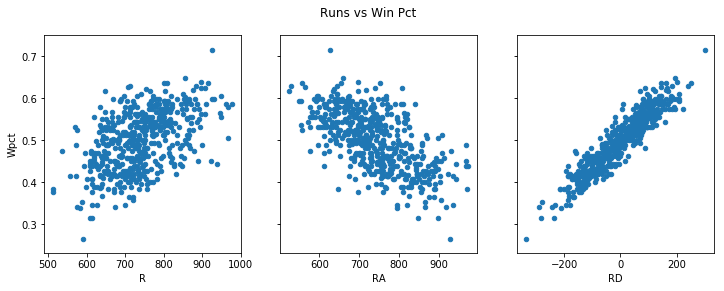

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axarr = plt.subplots(ncols=3, figsize=(12,4), sharey=True)
mlb_df.plot.scatter(ax=axarr[0], x='R', y='Wpct')
mlb_df.plot.scatter(ax=axarr[1], x='RA', y='Wpct')
mlb_df.plot.scatter(ax=axarr[2], x="RD", y='Wpct')
fig.suptitle("Runs vs Win Pct");

### Linear Fit

Let's compute a linear fit for wins against run differential.  This is given by the equation
$$
    \text{Linear Win pct} = \alpha  + \beta \cdot \text{Run Differential per Game}
$$
where $\alpha$ gives $\text{Average Win Pct}$ (which we reason should be $0.500$) and $\beta$ gives $\text{Wins per Unit Run Differential}$.

The next cell computes $\alpha=0.500$ and $\beta = 0.101$.  This shows that the average winning percentage is naturally .500 and that an improvement of total run differential by 10 runs will increase the number of expected wins by 1 (or increase expected winning percentage by $0.006 = .101 \cdot 10\ /\ 162$).

Computed Linear Fit:
xWpct = 0.500 + 0.101 * RDperG


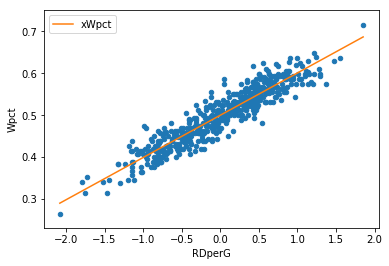

In [3]:
import numpy as np
import statsmodels.formula.api as smf

# Compute a linear fit
formula = 'Wpct ~ RDperG'
results = smf.ols(formula, data=mlb_df).fit()
# print(results.summary2())  # print a summary of the results (not necessary but shows how diagnotic information)

alpha, beta = results.params['Intercept'], results.params['RDperG']

print("Computed Linear Fit:")
print("====================")
s = "xWpct = {alpha:.3f} + {beta:.3f} * RDperG".format(alpha=alpha, beta=beta)
print(s)

fig, ax = plt.subplots()
mlb_df.plot.scatter(ax=ax, x="RDperG", y='Wpct')

rd = np.linspace(mlb_df['RDperG'].min(), mlb_df['RDperG'].max())
xW = alpha + beta * rd
mlb_df['xWpct'] = results.fittedvalues
plt.plot(rd, xW, color='C1', label='xWpct')
plt.legend();

### Pythagorean Expectation

Recall from above Bill James' formula for Pythagorean Expectation:
$$
    \text{Pythagorean Win Pct}
        = \frac{\text{Runs Scored}^2}{\text{Runs Scored}^2 + \text{Runs Allowed}^2}
        = \frac{\text{Runs Scored}\ /\ \text{Runs Allowed}}{1 + (\text{Runs Scored}\ /\ \text{Runs Allowed})^2}
$$

What's the difference between Pythagorean Expectation and our linear fit above?
$$
    \text{Linear Win Pct} = 0.500 + 0.101 \cdot \text{Run Differential per Game}
$$

Performance wise, both formulas do the trick.  Normally we'd opt for a simpler formula like the linear win percentage formula but the Pythagorean formula is still fairly simple and elegant.  There are a few other areas where the Pythagorean formula is a bit better.

If the run differential is every really high or low, the linear win percentage formula could be greater than 1 or negative.  The Pythagorean formula also does a bit better in handling teams at the extremes (like the 2001 Seattle Mariners or 2003 Detroit Tigers).  

Finally, the Pythagorean formula better quantifies performance by being dependent on the run ratio,
$$
    \text{Runs Scored}\ /\ \text{Runs Allowed}
$$
instead of the run differential
$$
    \text{Runs Scored} - \text{Runs Allowed}.
$$

To see why this is more desirable, consider an era where defense and pitching are strong and fewer runs scored.  The linear win percentage formula will always require a 10 run change in total run differential to increase expected wins by 1.  A run poor environment like this should require fewer runs in order to increase winning percentage.  Conversely, a run rich environment should require more runs.  The Pythagorean formula captures this .

The plot in the following cell shows how win percentage, expected win percentage from the linear fit, and the Pythagorean Expectation compare as a function of the perforamnce ratio.

In [4]:
K = 2
mlb_df['RR'] = mlb_df['R'] / mlb_df['RA']
mlb_df['pythag_Wpct'] = 1 / (1 + (1 / mlb_df['RR'])**K)

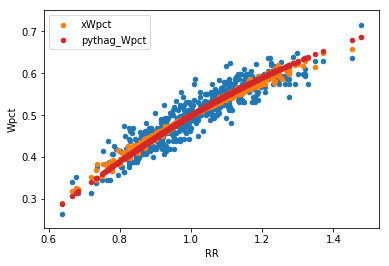

In [5]:
fig, ax = plt.subplots()
mlb_df.plot.scatter(ax=ax, x="RR", y='Wpct')
mlb_df.plot.scatter(ax=ax, x="RR", y='xWpct', color='C1', label='xWpct')
mlb_df.plot.scatter(ax=ax, x="RR", y='pythag_Wpct', color='C3', label='pythag_Wpct')
plt.legend()
ax.set_ylabel('Wpct');

### Deriving the Pythagorean Expectation Formula

Where does the exponent come from in the Pythagorean Expectation formula?  Consider the ratio of wins to losses:
$$
    \frac{\text{Pythagorean Win Pct}}{\text{Pythagorean Loss Pct}}
        = \frac{\text{Pythagorean Win Pct}}{1 - \text{Pythagorean Win Pct}}
        = \left(\frac{\text{Runs Scored}}{\text{Runs Allowed}}\right)^2
$$
If we take the log we get a linear relationship:
$$
    \log\left(\frac{\text{Pythagorean Win Pct}}{\text{Pythagorean Loss Pct}}\right)
        = 2\log\left(\frac{\text{Runs Scored}}{\text{Runs Allowed}}\right)
$$

This suggests that we should explore the log win-loss ratio on the left-hand side and the log run ratio on the right-hand side. 

In the next cell, we show the scatter plot and the result of the linear fit
$$
    \text{Log Win-Loss Ratio} = K \cdot \text{Log Run Ratio}
$$

The linear relationship of the log values is clear.  And our fit produces a value of $K = 1.87$.  This shows where the Pythagorean Expectation formula comes from.  While not exactly the same, taking $K=2$ is "good enough".

Computed Linear Fit:
xlog_Wrat = 1.87 * log_RR


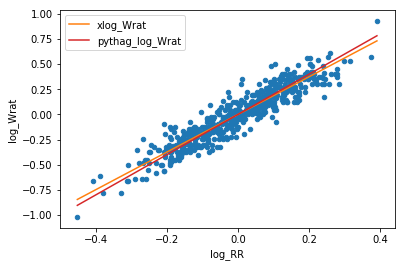

In [8]:
mlb_df['log_RR'] = np.log(mlb_df['RR'])
mlb_df['log_Wrat'] = np.log(mlb_df["W"] / mlb_df["L"])

formula = 'log_Wrat ~ 0 + log_RR'
results = smf.ols(formula, data=mlb_df).fit()
# print(results.summary2())  # print a summary of the results (not necessary but shows how diagnotic information)

K = results.params['log_RR']

print("Computed Linear Fit:")
print("====================")
s = "xlog_Wrat = {K:.2f} * log_RR".format(K=K)
print(s)

fig, ax = plt.subplots()
mlb_df.plot.scatter(ax=ax, x='log_RR', y='log_Wrat')


log_RR = np.linspace(mlb_df['log_RR'].min(), mlb_df['log_RR'].max())
pythag_log_Wrat = log_RR * 2
xlog_Wrat = log_RR * K
mlb_df['xlog_Wrat'] = results.fittedvalues
mlb_df['pythag_Wpct_new'] = 1 / (1 + mlb_df['RR']**K)

plt.plot(log_RR, xlog_Wrat, color='C1', label='xlog_Wrat')
plt.plot(log_RR, pythag_log_Wrat, color='C3', label='pythag_log_Wrat')
plt.legend();

### Pythagorean Luck

One thing we can use Pythagorean Expectation for is determining the extent of luck or lack of it.  Given that we have a formula for expected winning percentage given a run differential, we consider deviations from the expectation to be attributable to luck.  Why?  Our assumption is that a team cannot perform magic and optimally allocate runs so that it wins many games by only one run.  Instead, the spread of runs is uniform and random.  For example, a lucky team would be one with a narrow run differential that managed to win a lot of one run games despite a poor run differential.  

We compute Pythagorean Luck as the difference in wins and expected wins:
$$
    \text{Pythagorean Luck} = \text{Games} * (\text{Win Pct} - \text{Pythagorean Win Pct})
$$


In [9]:
mlb_df['pythag_luck'] = mlb_df['G'] * (mlb_df['Wpct'] - mlb_df['pythag_Wpct'])

In [10]:
mlb_df.sort_values(by='pythag_luck', ascending=False).head(10)

,yearID,lgID,teamID,franchID,G,W,L,R,RA,name,...,RDperG,xWpct,RR,pythag_Wpct,log_Rrat,log_Wrat,xlog_Wrat,pythag_Wpct_new,log_RR,pythag_luck
2832,2016,AL,TEX,TEX,162,95,67,765,757,Texas Rangers,...,0.049383,0.504906,1.010568,0.505256,0.010513,0.349184,0.019661,0.495085,0.010513,13.148512
2475,2005,NL,ARI,ARI,162,77,85,696,856,Arizona Diamondbacks,...,-0.987654,0.400398,0.813084,0.397991,-0.206921,-0.098846,-0.386999,0.595560,-0.206921,12.525397
2463,2004,AL,NYA,NYY,162,101,61,897,808,New York Yankees,...,0.549383,0.555294,1.110149,0.552058,0.104494,0.504247,0.195433,0.451297,0.104494,11.566674
2578,2008,AL,LAA,ANA,162,100,62,765,697,Los Angeles Angels of Anaheim,...,0.419753,0.542231,1.097561,0.546411,0.093090,0.478036,0.174105,0.456583,0.093090,11.481382
2535,2007,NL,ARI,ARI,162,90,72,712,732,Arizona Diamondbacks,...,-0.123457,0.487488,0.972678,0.486152,-0.027703,0.223144,-0.051812,0.512950,-0.027703,11.243337
2687,2012,AL,BAL,BAL,162,93,69,712,705,Baltimore Orioles,...,0.043210,0.504284,1.009929,0.504940,0.009880,0.298493,0.018479,0.495380,0.009880,11.199737
2825,2016,NL,PHI,PHI,162,71,91,610,796,Philadelphia Phillies,...,-1.148148,0.384224,0.766332,0.369985,-0.266140,-0.248180,-0.497756,0.621932,-0.266140,11.062403
2618,2009,AL,SEA,SEA,162,85,77,640,692,Seattle Mariners,...,-0.320988,0.467582,0.924855,0.461020,-0.078118,0.098846,-0.146102,0.536461,-0.078118,10.314700
2452,2004,NL,CIN,CIN,162,76,86,750,907,Cincinnati Reds,...,-0.969136,0.402264,0.826902,0.406093,-0.190069,-0.123614,-0.355483,0.587946,-0.190069,10.212854
2374,2001,NL,NYN,NYM,162,82,80,642,713,New York Mets,...,-0.438272,0.455762,0.900421,0.447745,-0.104893,0.024693,-0.196179,0.548888,-0.104893,9.465318


In [11]:
mlb_df.sort_values(by='pythag_luck', ascending=True).head(10)

,yearID,lgID,teamID,franchID,G,W,L,R,RA,name,...,RDperG,xWpct,RR,pythag_Wpct,log_Rrat,log_Wrat,xlog_Wrat,pythag_Wpct_new,log_RR,pythag_luck
2764,2014,AL,OAK,OAK,162,88,74,729,572,Oakland Athletics,...,0.969136,0.597595,1.274476,0.618944,0.242535,0.173272,0.453608,0.388503,0.242535,-12.268967
2512,2006,AL,CLE,CLE,162,78,84,870,782,Cleveland Indians,...,0.543210,0.554672,1.112532,0.553118,0.106638,-0.074108,0.199444,0.450304,0.106638,-11.605122
2803,2015,AL,TOR,TOR,162,93,69,891,670,Toronto Blue Jays,...,1.364198,0.637408,1.329851,0.638794,0.285067,0.298493,0.533154,0.369782,0.285067,-10.484622
2364,2001,NL,COL,COL,162,73,89,923,906,Colorado Rockies,...,0.104938,0.510505,1.018764,0.509294,0.018590,-0.198177,0.034768,0.491309,0.018590,-9.505611
2794,2015,AL,OAK,OAK,162,68,94,694,729,Oakland Athletics,...,-0.216049,0.478157,0.951989,0.475419,-0.049202,-0.323787,-0.092021,0.522989,-0.049202,-9.017869
2623,2009,AL,TOR,TOR,162,75,87,798,771,Toronto Blue Jays,...,0.166667,0.516726,1.035019,0.517203,0.034420,-0.148420,0.064375,0.483912,0.034420,-8.786938
2503,2005,AL,TOR,TOR,162,80,82,775,705,Toronto Blue Jays,...,0.432099,0.543475,1.099291,0.547192,0.094665,-0.024693,0.177050,0.455853,0.094665,-8.645060
2753,2014,NL,COL,COL,162,66,96,755,818,Colorado Rockies,...,-0.388889,0.460739,0.922983,0.460013,-0.080145,-0.374693,-0.149893,0.537403,-0.080145,-8.522152
2337,2000,NL,HOU,HOU,162,72,90,938,944,Houston Astros,...,-0.037037,0.496197,0.993644,0.496812,-0.006376,-0.223144,-0.011925,0.502981,-0.006376,-8.483533
2389,2002,AL,BOS,BOS,162,93,69,859,665,Boston Red Sox,...,1.197531,0.620612,1.291729,0.625267,0.255982,0.298493,0.478758,0.382546,0.255982,-8.293208


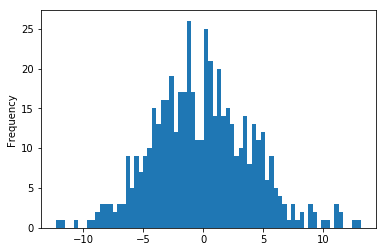

In [12]:
mlb_df['pythag_luck'].plot.hist(bins=70)

### 10 Runs to a Win?

There is a common approximation in baseball analysis that it takes about 10 extra wins to generate a win.  That is, all things being equal, if you add 10 runs to a team's season total (or take away from their runs allowed total, or in general to their differential), you should expect about an increase of 1 win.  Can we derive this empirically?  Yes!

First off, from the linear formula for expected winning percentage, it is clear that increasing the run differential by 10 runs translated to about 1 win (this is found by $1 / \beta$).  A similar value will hold for the Pythagorean Expectation which we explore here.

To find the number of runs needed to increase wins, we first take a derivative of the Pythagorean Expectation with respect to runs scored.  This will give us the change in wins per run scored.  From a little calculus and algebra:
$$
    \text{Change in Wins per Run Scored}
    = 2\frac{\text{Games}}{\text{Runs Scored}} \cdot
        \left(
            \frac
                {\text{Runs Allowed}\ /\ \text{Runs Scored}}
                {1 + (\text{Runs Allowed}\ /\ \text{Runs Scored})^2}
        \right)^{2}
$$

We invert the formula to get the change in runs scored per win.  This gives us what we're interested in.  We can also convert Runs Scored and Runs Allowed to 'per game' values and drop Games.
$$
    \text{Change in Runs Scored per Win}
    = \frac12 \cdot
        \text{Runs Scored per Game} \cdot
        \left(
            \frac
                {1 + (\text{Runs Allowed per Game}\ /\ \text{Runs Scored per Game})^2}
                {\text{Runs Allowed per Game}\ /\ \text{Runs Scored per Game}}
        \right)^{2}
$$

Okay, great!  But what does this formula tell us?  As is, it's not particularly illuminating but we can plug in some values and get a feel for it.

In the next cell, we produce a runs-to-wins table for various runs scoring enviroments.  Here's what we can observe:
+ In general, when more runs are scored (lower right corner), more runs are needed to increase wins.  
+ When fewer runs are scored (upper left corner), fewer runs are needed to increase wins.
+ The value of an extra run (ie. its marginal value) is decreasing as more runs are scored.

To put this in historical perspective, in 1968 runs per game was as low as 3.4 and in 2000 runs per game was as high as 5.2.  The varying level offense in baseball shows that the value of a hitter in terms of wins can vary considerably depending on the run scoring environment.

In [10]:
def runs_per_win(R=5, RA=5):
    return R * (((RA / R)**2 + 1.) / (RA / R))**2 / 2.

runs = np.arange(3, 6.5, .5)
run_vals = np.around(
    [[runs_per_win(R=r, RA=ra) for r in runs] for ra in runs], decimals=2)
runs_to_wins = pd.DataFrame(
    run_vals,
    index=pd.Series(runs, name='RAperG'),
    columns=pd.Series(runs, name='RperG')
)
runs_to_wins

RperG,3.0,3.5,4.0,4.5,5.0,5.5,6.0
RAperG,,,,,,,
3.0,6.00,7.17,8.68,10.56,12.84,15.56,18.75
3.5,6.14,7.00,8.14,9.58,11.33,13.40,15.84
4.0,6.51,7.13,8.00,9.13,10.51,12.15,14.08
4.5,7.04,7.45,8.11,9.00,10.11,11.45,13.02
5.0,7.71,7.93,8.40,9.10,10.00,11.10,12.40
5.5,8.49,8.53,8.84,9.37,10.09,11.00,12.09
6.0,9.38,9.24,9.39,9.77,10.34,11.08,12.00


## II. On You Own: Pythagorean Expectation for NBA

In this portion of the lab, you will perform the same analysis for the NBA reusing much of the same code from above but tweaked whereever necessary.  If you are unsure how to do something, just look to the corresponding part of the MLB section and emulate the code.  The data is loaded in the first cell.

In [74]:
nba_df = pd.read_csv(
    "nba_team_season_data.csv", usecols=[1, 2, 3, 8, 9, 10, 11, 12, 16, 17, 38, 59, 60, 61])
nba_df.head()

,lg_id,wins,losses,off_rtg,off_rtg_rel,def_rtg,def_rtg_rel,team_id,g,mp,pts,opp_pts,year,team
0,NBA,35.0,47.0,97.7,0.0,99.0,1.3,ATL,82.0,19755.0,8907.0,9024.0,1973-74,ATL
1,NBA,36.0,46.0,96.8,-0.9,99.1,1.4,SEA,82.0,19755.0,8774.0,8983.0,1973-74,OKC
2,NBA,47.0,35.0,95.6,-2.1,94.2,-3.5,CAP,82.0,19730.0,8353.0,8231.0,1973-74,WAS
3,NBA,54.0,28.0,96.7,-1.0,93.6,-4.1,CHI,82.0,19780.0,8368.0,8097.0,1973-74,CHI
4,NBA,49.0,33.0,97.4,-0.3,94.7,-3.0,NYK,82.0,19780.0,8306.0,8080.0,1973-74,NYK


#### 1. The first thing we need to do is compute the winning percentage $\text{Win Pct} = W / G$.

In [75]:
nba_df['Wpct'] = nba_df['wins'] / nba_df['g']

#### 2. Then we need to compute the following quantities
\begin{align*}
    \text{Net Points} & = \text{Points Scored} - \text{Points Allowed} \\
    \text{Points per Game} & = \text{Points Scored}\ /\ \text{Games} \\
    \text{Opp Points per Game} & = \text{Points Allowed}\ /\ \text{Games} \\
    \text{Net Points per Game} & = \text{Net Points}\ /\ \text{Games} \\
    \text{Net Rating} & = \text{Off Rating} - \text{Def Rating}
\end{align*}

Question: Should we use 82 or perhaps something else?  What happened in the NBA that might necessitate not using 82?

In [76]:
nba_df['net_pts'] = nba_df['pts'] - nba_df['opp_pts']
nba_df['ppg'] = nba_df['pts'] / nba_df['g']
nba_df['opp_ppg'] = nba_df['opp_pts'] / nba_df['g']
nba_df['net_ppg'] = nba_df['net_pts'] / nba_df['g']
nba_df['net_rtg'] = nba_df['off_rtg'] - nba_df['def_rtg']

Show the two 10 team seasons by Net Rating.

In [78]:
nba_df.sort_values(by='net_rtg', ascending=False).head(10)

,lg_id,wins,losses,off_rtg,off_rtg_rel,def_rtg,def_rtg_rel,team_id,g,mp,pts,opp_pts,year,team,Wpct,net_pts,ppg,opp_ppg,net_ppg,net_rtg
536,NBA,72.0,10.0,115.2,7.6,101.8,-5.8,CHI,82.0,19730.0,8625.0,7621.0,1995-96,CHI,0.878049,1004.0,105.182927,92.939024,12.243902,13.4
562,NBA,69.0,13.0,114.4,7.7,102.4,-4.3,CHI,82.0,19730.0,8458.0,7572.0,1996-97,CHI,0.841463,886.0,103.146341,92.341463,10.804878,12.0
1164,NBA,67.0,15.0,115.6,6.8,104.0,-4.8,GSW,82.0,19780.0,9503.0,8549.0,2016-17,GSW,0.817073,954.0,115.890244,104.256098,11.634146,11.6
881,NBA,66.0,16.0,110.2,2.7,98.9,-8.6,BOS,82.0,19755.0,8245.0,7404.0,2007-08,BOS,0.804878,841.0,100.548780,90.292683,10.256098,11.3
1142,NBA,67.0,15.0,110.3,3.9,99.0,-7.4,SAS,82.0,19705.0,8490.0,7618.0,2015-16,SAS,0.817073,872.0,103.536585,92.902439,10.634146,11.3
433,NBA,67.0,15.0,115.5,7.3,104.5,-3.7,CHI,82.0,19830.0,9011.0,8155.0,1991-92,CHI,0.817073,856.0,109.890244,99.451220,10.439024,11.0
1131,NBA,73.0,9.0,114.5,8.1,103.8,-2.6,GSW,82.0,19880.0,9421.0,8539.0,2015-16,GSW,0.890244,882.0,114.890244,104.134146,10.756098,10.7
1107,NBA,67.0,15.0,111.6,6.0,101.4,-4.2,GSW,82.0,19730.0,9016.0,8188.0,2014-15,GSW,0.817073,828.0,109.951220,99.853659,10.097561,10.2
906,NBA,66.0,16.0,112.4,4.1,102.4,-5.9,CLE,82.0,19780.0,8223.0,7491.0,2008-09,CLE,0.804878,732.0,100.280488,91.353659,8.926829,10.0
1036,NBA,60.0,22.0,112.4,6.5,102.6,-3.3,OKC,82.0,19830.0,8669.0,7914.0,2012-13,OKC,0.731707,755.0,105.719512,96.512195,9.207317,9.8


#### 3. Reusing the code from the MLB portion (but with changes to fit for the NBA example), compute the model
$$
    \text{Linear Win Pct} = \alpha  + \beta \cdot \text{Net Points per Game}
$$
where $\alpha$ gives $\text{Average Win Pct}$ and $\beta$ gives $\text{Wins per Unit Net Points}$.

Also:
+ Plot the linear model results as we did with MLB
+ Question: For what values of Net PPG does $\text{Linear Win Pct} < 0$ and $\text{Linear Win Pct} > 1$?

Computed Linear Fit:
xWpct = 0.500 + 0.032 * NetPPG


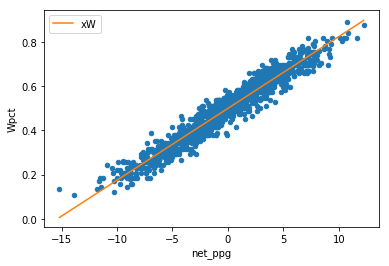

In [79]:
# Compute a linear fit
formula = 'Wpct ~ net_ppg'
results = smf.ols(formula, data=nba_df).fit()
# print(results.summary2())  # print a summary of the results (not necessary but shows how diagnotic information)

alpha, beta = results.params['Intercept'], results.params['net_ppg']
print("Computed Linear Fit:")
print("====================")
s = "xWpct = {alpha:.3f} + {beta:.3f} * NetPPG".format(alpha=alpha, beta=beta)
print(s)

fig, ax = plt.subplots()
nba_df.plot.scatter(ax=ax, x="net_ppg", y='Wpct')

net_ppg = np.linspace(nba_df['net_ppg'].min(), nba_df['net_ppg'].max())
xWpct = alpha + beta * net_ppg
nba_df['xWpct'] = results.fittedvalues
plt.plot(net_ppg, xWpct, color='C1', label='xW')
plt.legend();

From the estimated value of $\beta$, which should be about $0.03$, what is the "Net Points per Win" value of the linear model?  What is the "Net PPG per Win" value?

In [80]:
# Net pts per Win and net ppg per Win
1 / beta, 1 / beta / 82

(30.788448438754894, 0.37546888339944995)

#### 4. Now compute the following values:
\begin{align*}
    \text{Performance Ratio} & = \text{Points Scored}\ /\ \text{Points Allowed} \\
    \text{Log Performance Ratio} & = \log \text{Performance Ratio} \\
    \text{Log Win Ratio} & = \log \text{Wins}\ /\ \text{Losses}
\end{align*}

In [81]:
nba_df['pts_pr'] = nba_df['pts'] / nba_df['opp_pts']
nba_df['log_pts_pr'] = np.log(nba_df['pts_pr'])
nba_df['log_Wrat'] = np.log(nba_df['wins'] / nba_df['losses'])

#### 5. Again, reusing the MLB code with appropriate changes, compute a Pythagorean exponent for the NBA

+ Plot the results of the model for the Pythagorean exponent


You should get a large value (around 14).  We could perform this analysis on all sorts of sports.  What does it mean for a sport to have a large Pythagorean exponent versus a small exponent?  Put another way, if a team scores more points than it allows, in which sport would you expect that team to have a higher winning percentage, one with a large exponent or one with a small exponent?


Computed Linear Fit:
xlog_Wrat = 14.35 * log_pts_pr


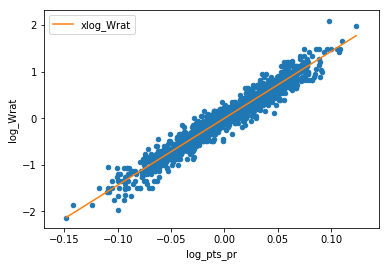

In [82]:
formula = 'log_Wrat ~ 0 + log_pts_pr'
results = smf.ols(formula, data=nba_df).fit()
# print(results.summary2())  # print a summary of the results (not necessary but shows how diagnotic information)

K = results.params['log_pts_pr']
print("Computed Linear Fit:")
print("====================")
s = "xlog_Wrat = {K:.2f} * log_pts_pr".format(K=K)
print(s)

fig, ax = plt.subplots()
nba_df.plot.scatter(ax=ax, x='log_pts_pr', y='log_Wrat')

log_pts_pr = np.linspace(nba_df['log_pts_pr'].min(), nba_df['log_pts_pr'].max())
xlog_Wrat = log_pts_pr * K
nba_df['xlog_Wrat'] = results.fittedvalues

plt.plot(log_pts_pr, xlog_Wrat, color='C1', label='xlog_Wrat')
plt.legend();

#### 6. Using the computed exponent*, compute the Pythagorean Expectation

+ For team with really poor net scoring performance, how does the Pythagorean formula compare to the linear formula?  Which seems to perform better in this case?

*To skip the previous cell if it isn't working immediately: use 14. 

In [4]:
nba_df['pythag_Wpct'] = 1 / (1 + (1 / nba_df['pts_pr'])**K)

# Plot of Pythagorean Expectation
fig, ax = plt.subplots()
nba_df.plot.scatter(ax=ax, x="pts_pr", y='Wpct')
nba_df.plot.scatter(ax=ax, x="pts_pr", y='xWpct', color='C1', label='xWpct')
nba_df.plot.scatter(ax=ax, x="pts_pr", y='pythag_Wpct', color='C3', label='pythag_Wpct')
plt.legend()
ax.set_ylabel('Wpct');

NameError: name 'nba_df' is not defined

#### 7. Compute Pythagorean Luck

+ Who have been the "luckiest" teams?
+ Who have been the "unluckiest"?

In [86]:
nba_df['pythag_luck'] = nba_df['g'] * (nba_df['Wpct'] - nba_df['pythag_Wpct'])

In [87]:
nba_df.sort_values(by='pythag_luck', ascending=False).head(10)

,lg_id,wins,losses,off_rtg,off_rtg_rel,def_rtg,def_rtg_rel,team_id,g,mp,...,opp_ppg,net_ppg,net_rtg,xWpct,pts_pr,log_pts_pr,log_Wrat,xlog_Wrat,pythag_Wpct,pythag_luck
75,NBA,44.0,38.0,96.5,-3.0,98.3,-1.2,BOS,82.0,19830.0,...,106.512195,-1.975610,-1.8,0.435773,0.981452,-0.018722,0.146603,-0.268677,0.433232,8.474981
439,NBA,38.0,44.0,106.7,-1.5,110.9,2.7,MIA,82.0,19830.0,...,109.182927,-4.207317,-4.2,0.363288,0.961465,-0.039297,-0.146603,-0.563930,0.362639,8.263631
818,NBA,41.0,41.0,104.1,-2.1,107.0,0.8,UTA,82.0,19880.0,...,94.987805,-2.634146,-2.9,0.414384,0.972269,-0.028123,0.000000,-0.403584,0.400452,8.162974
269,NBA,32.0,50.0,105.4,-1.8,112.1,4.9,LAC,82.0,19755.0,...,115.548780,-6.926829,-6.7,0.274959,0.940053,-0.061819,-0.446287,-0.887142,0.291700,8.080606
506,NBA,59.0,23.0,114.5,6.2,110.4,2.1,PHO,82.0,19830.0,...,106.768293,3.878049,4.1,0.625898,1.036322,0.035678,0.942043,0.512000,0.625275,7.727434
502,NBA,48.0,34.0,109.1,0.8,109.4,1.1,LAL,82.0,19905.0,...,105.292683,-0.219512,-0.3,0.492810,0.997915,-0.002087,0.344840,-0.029949,0.492513,7.613909
1120,NBA,42.0,40.0,105.4,-1.0,107.8,1.4,MEM,82.0,19830.0,...,101.341463,-2.243902,-2.4,0.427059,0.977858,-0.022391,0.048790,-0.321321,0.420354,7.530986
876,NBA,34.0,48.0,104.0,-3.5,109.4,1.9,NJN,82.0,19830.0,...,100.878049,-5.060976,-5.4,0.335561,0.949831,-0.051471,-0.344840,-0.738645,0.323300,7.489362
558,NBA,54.0,28.0,110.9,4.2,108.9,2.2,CHH,82.0,19805.0,...,97.012195,1.865854,2.0,0.560543,1.019233,0.019051,0.656780,0.273387,0.567924,7.430221
1131,NBA,73.0,9.0,114.5,8.1,103.8,-2.6,GSW,82.0,19880.0,...,104.134146,10.756098,10.7,0.849295,1.103291,0.098297,2.093235,1.410624,0.803864,7.083130


In [100]:
nba_df.sort_values(by='pythag_luck', ascending=True).head(10)

,lg_id,wins,losses,off_rtg,off_rtg_rel,def_rtg,def_rtg_rel,team_id,g,mp,...,opp_ppg,net_ppg,net_rtg,xWpct,pts_pr,log_pts_pr,log_Wrat,xlog_Wrat,pythag_Wpct,pythag_luck
290,NBA,31.0,51.0,105.9,-1.3,106.0,-1.2,SEA,82.0,19930.0,...,104.536585,-0.097561,-0.1,0.496771,0.999067,-0.000934,-0.497838,-0.013399,0.496650,-9.725320
73,NBA,34.0,48.0,98.1,-1.4,97.5,-2.0,PHO,82.0,19730.0,...,104.182927,0.731707,0.6,0.523706,1.007023,0.006999,-0.344840,0.100436,0.525088,-9.057210
605,NBA,37.0,45.0,105.3,0.3,103.5,-1.5,DET,82.0,19955.0,...,92.585366,1.573171,1.8,0.551036,1.016992,0.016849,-0.195745,0.241790,0.560155,-8.932695
109,NBA,38.0,44.0,106.0,2.2,104.0,0.2,MIL,82.0,19880.0,...,111.841463,2.219512,2.0,0.572029,1.019845,0.019651,-0.146603,0.282001,0.570037,-8.743003
14,NBA,32.0,50.0,100.3,2.6,100.5,2.8,HOU,82.0,19855.0,...,107.573171,-0.134146,-0.2,0.495583,0.998753,-0.001248,-0.446287,-0.017907,0.495523,-8.632923
1020,NBA,35.0,31.0,103.9,-0.7,99.2,-5.4,PHI,66.0,15915.0,...,89.393939,4.242424,4.7,0.637733,1.047458,0.046366,0.121361,0.665378,0.660467,-8.590848
890,NBA,41.0,41.0,110.2,2.7,107.0,-0.5,TOR,82.0,19830.0,...,97.280488,2.902439,3.2,0.594211,1.029836,0.029399,0.000000,0.421898,0.603937,-8.522855
1081,NBA,40.0,42.0,108.9,2.2,106.2,-0.5,MIN,82.0,19855.0,...,104.256098,2.670732,2.7,0.586685,1.025617,0.025294,-0.048790,0.362989,0.589764,-8.360640
45,NBA,24.0,58.0,95.2,-3.1,98.0,-0.3,CHI,82.0,19780.0,...,98.792683,-2.902439,-2.8,0.405670,0.970621,-0.029819,-0.882389,-0.427924,0.394622,-8.359015
501,NBA,44.0,38.0,109.7,1.4,105.7,-2.6,POR,82.0,19705.0,...,99.243902,3.817073,4.0,0.623918,1.038462,0.037740,0.146603,0.541596,0.632183,-7.839047


#### 8. Compute a table of points per game to wins

+ A function with the PPG per Win formula has been provided
+ Compute the points per win for various ppg values


If a top star averages 20-30 points per game, give your own estimate (with a bit of explanation why) of how many extra games we should expect a team without the star to lose.

In [ ]:
def ppg_per_win(ppg, opp_ppg, K):
    return ppg * ((opp_ppg / ppg)**K + 1.)**2 / (opp_ppg / ppg)**K / K

In [103]:
ppg_rng = np.arange(80, 135, 5)
ppg_vals = np.around(
    [[ppg_per_win(ppg, opp_ppg, K) for ppg in ppg_rng] for opp_ppg in ppg_rng], decimals=2)
ppg_to_wins = pd.DataFrame(
    ppg_vals,
    index=pd.Series(ppg_rng, name='opp_ppg'),
    columns=pd.Series(ppg_rng, name='ppg')
)
ppg_to_wins

ppg,80,85,90,95,100,105,110,115,120,125,130
opp_ppg,,,,,,,,,,,
80,22.30,28.47,47.70,91.77,185.55,377.12,755.44,1480.24,2830.74,5283.30,9632.96
85,26.79,23.69,29.55,47.24,86.39,166.79,325.56,629.55,1195.71,2223.60,4046.29
90,42.40,27.91,25.09,30.67,47.08,82.28,152.28,286.36,535.96,988.91,1791.84
95,77.28,42.27,29.05,26.48,31.82,47.14,79.10,140.87,255.96,464.72,834.62
100,148.44,73.44,42.37,30.23,27.87,33.00,47.38,76.66,131.78,231.94,409.37
105,287.33,135.02,70.52,42.65,31.43,29.27,34.21,47.77,74.78,124.47,212.70
110,549.41,251.57,124.59,68.32,43.07,32.65,30.66,35.43,48.27,73.36,118.53
115,1029.73,465.32,224.11,116.37,66.66,43.61,33.89,32.05,36.67,48.87,72.30
120,1887.16,846.96,401.97,202.63,109.82,65.43,44.25,35.14,33.45,37.92,49.56


## III. Wrap Up

And that wraps up our exploration of runs, points, and wins and how we can link them through a beautiful empirical rule like the Pythagorean Expectation formula.